 <h1><center>LOAN DEFAULT PREDICTION USING ML ALGORITHMS</center></h1>

<h2 style="text-align:right">Nandan Rajeev </h2>

## INTRODUCTION 
Loan default prediction is a very important aspect of loan approval in banks. From the previous data of customers, banks can now take loan approval decisions with a greater certainity in being able to recover the money. 
In this project, we will explore some of the various machine learning models which can be utilized in taking such decisions. We will also be comparing the accuracies of each of these models at the end.  
This project was undertaken for the completion of the **Machine Learning with Python** course, provided by IBM.
### Loan default prediction models are created and trained using the following different algorithms 
#### * K Nearest Neighbors
#### * Decision Trees
#### * Support Vector Machines
#### * Logistic Regression



In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

In [2]:
# Downloading and loading the dataset provided by IBM

!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv


--2020-09-22 17:56:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.08s   

2020-09-22 17:56:02 (266 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [3]:
df = pd.read_csv('loan_train.csv')
print("This will be the dataset used to train and test the model:")
df.head()

This will be the dataset used to train and test the model:


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


# Data Preparation

In [4]:
df['education'].replace(to_replace=['Bechalor'], value=['Bachelor'],inplace=True)
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


### We need to see if the non-integer data has a significant effect on the outcome. If it does, it needs to be transformed into integers using methods such as one hot coding 

### Examining the day of the week the loan was provided

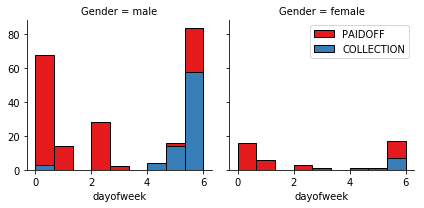

In [6]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so we apply Feature binarization to set a threshold value as less than day 4 

In [7]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Now examining genders

In [8]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay their loan
So now, let's set value of male to 0 and female to 1

In [9]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


### Now examining education

In [10]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bachelor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Master or Above doesn't seem to influence the outcome so we can drop it. We can consider the other qualifications by one hot encoding.

In [11]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Now creating a features set of independent variables as X and a set for dependant (predictor) variable as y

In [12]:
X = Feature
y = df['loan_status'].values

### Normalizing the data

In [13]:
X= preprocessing.StandardScaler().fit(X).transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


### Splitting the dataset 

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# Classification

## K Nearest Neighbour (KNN)

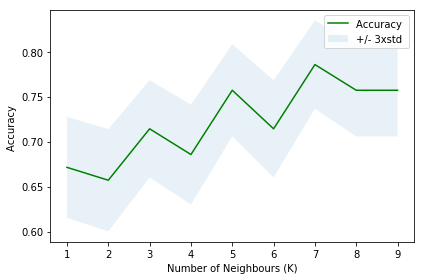

The best accuracy was 0.7857142857142857 with k= 7


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
     
    neighK = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    PredKNN2=neighK.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, PredKNN2)

    
    std_acc[n-1]=np.std(PredKNN2==y_test)/np.sqrt(PredKNN2.shape[0])

# Plotting values of K against Accuracy to see best K value

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was", mean_acc.max(), "with k=", mean_acc.argmax()+1) 


In [16]:
# Now fitting the model with K = 7
# Refitting model with best K 
k = 7 
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
PredKNN = neigh.predict(X_test)
print ("Actual values",y_test[0:5])
print ("Predicted values",PredKNN[0:5])

Actual values ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Predicted values ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


## Decision Trees

In [17]:
from sklearn.tree import DecisionTreeClassifier
LoanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
LoanTree.fit(X_train,y_train)
PredTree = LoanTree.predict(X_test)
print('Actual values', y_test[0:5])
print('Predicted values', PredTree[0:5])

Actual values ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Predicted values ['COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


## Support Vector Machines (SVM)

In [18]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', gamma = 'scale')
clf.fit(X_train, y_train) 
PredSVM = clf.predict(X_test)
print('Actual values', y_test[0:5])
print('Predicted values', PredSVM[0:5])

Actual values ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Predicted values ['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
PredLR = LR.predict(X_test)
print('Actual values', y_test[0:5])
print('Predicted values', PredLR[0:5])


Actual values ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Predicted values ['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


# Model Validation

To check the accuracy of different algorithms when trying to choose the best one, it is desirable to carry out the evaluation tests using a seperate validation dataset which has not been used in the previous train/test set. This is especially useful when the previous test set is used in choosing the best model (such as in KNN, where the test data is used to choose the best value of k).

In [20]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [21]:
# Downloading the validation set
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-09-22 17:56:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-09-22 17:56:05 (290 MB/s) - ‘loan_test.csv’ saved [3642/3642]



## Data Preparation

In [22]:
test_df = pd.read_csv('loan_test.csv')
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_X = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
test_y = test_df['loan_status'].values

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


## Evaluation

### K Nearest Neighbour (KNN)

In [23]:
KNN_EVAL = neigh.predict(test_X)
print("K-Nearest Neighbors Jaccard index: %.2f" % jaccard_similarity_score(test_y, KNN_EVAL))
print("K-Nearest Neighbors F1-score: %.2f" % f1_score(test_y, KNN_EVAL, average='weighted') )

K-Nearest Neighbors Jaccard index: 0.67
K-Nearest Neighbors F1-score: 0.63


### Decision Trees

In [24]:
DT_EVAL = LoanTree.predict(test_X)
print("Decision Tree's Jaccard index: %.2f" % jaccard_similarity_score(test_y, DT_EVAL))
print("Decision Tree's F1-score: %.2f" % f1_score(test_y, DT_EVAL, average='weighted') )

Decision Tree's Jaccard index: 0.72
Decision Tree's F1-score: 0.74


### Support Vector Machines (SVM)

In [25]:
SVM_EVAL = clf.predict(test_X)
print("Support Vector Machine's Jaccard index: %.2f" % jaccard_similarity_score(test_y, SVM_EVAL))
print("Support Vector Machine's F1-score: %.2f" % f1_score(test_y, SVM_EVAL, average='weighted') )

Support Vector Machine's Jaccard index: 0.80
Support Vector Machine's F1-score: 0.76


### Logistic Regression

In [26]:
LR_EVAL = LR.predict(test_X)
print("Logistic Regression's Jaccard index: %.2f" % jaccard_similarity_score(test_y, LR_EVAL))
print("Logistic Regression's F1-score: %.2f" % f1_score(test_y, LR_EVAL, average='weighted') )
LR_prob = LR.predict_proba(test_X)
from sklearn.metrics import log_loss
print("Logistic Regression's Log Loss is",log_loss(test_y, LR_prob))

Logistic Regression's Jaccard index: 0.74
Logistic Regression's F1-score: 0.66
Logistic Regression's Log Loss is 0.5672153379912981


# Comparison 

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.67       | 0.63        | NA      |
| Decision Tree      | 0.72       | 0.74        | NA      |
| SVM                | 0.80       | 0.76        | NA      |
| Logistic Regression | 0.74       | 0.66        | 0.57       |

# Result

From the table above, we can see the accuracies of the different algorithms.
The SVM model seems to have given us the best result.